# Lecture 21: Verlet Integration

## Learning Objectives

By the end of this lecture, you should be able to:

1. **Differentiate between conservative and non-conservative forces** and compute forces on a system of particles using potential energy functions.
2. **Derive the Verlet integration algorithm** from the Taylor series expansion of particle positions.
3. **Implement the Verlet algorithm** to simulate the motion of particles interacting via the Lennard-Jones potential.
4. **Calculate velocities and energies** within the Verlet framework to analyze kinetic, potential, and total energy conservation in the system.

## Forces

To solve Newton's equations of motion for a system of particles, we need to calculate the forces acting on each particle. These forces are then used to update the positions and velocities over time. Forces can be classified into two main types: **conservative forces** and **non-conservative (dissipative) forces**.

### Conservative Forces

Conservative forces are those for which the work done moving an object between two points is independent of the path taken—it depends only on the initial and final positions. Examples include gravity, electrostatic forces, and elastic spring forces. Conservative forces depend solely on the positions of the particles. For such forces, we can define a potential energy function $U(\mathbf{r})$ such that the force is the negative gradient of the potential energy, *i.e.*,

$$
\mathbf{F} = -\nabla U(\mathbf{r}) = -\left( \frac{\partial U}{\partial x}, \frac{\partial U}{\partial y}, \frac{\partial U}{\partial z} \right)
$$

Since the potential energy is defined up to an arbitrary constant, adding a constant to $U(\mathbf{r})$ doesn't affect the force. In systems with only conservative forces, the total mechanical energy—sum of kinetic energy $T$ and potential energy $U$—is conserved, *i.e.*,

$$
E = T + U
$$

```{admonition} Conservation of Mechanical Energy
:class: warning
In an isolated system with only conservative forces, the total mechanical energy remains constant over time. However, if non-conservative forces are present or the system interacts with its surroundings, mechanical energy can change.
```

### Non-Conservative (Dissipative) Forces

Non-conservative or dissipative forces are forces for which the work done depends on the path taken and typically lead to a loss of mechanical energy from the system. This lost mechanical energy is usually transformed into other forms, such as heat. Examples include friction, air resistance, and viscous drag forces. In the presence of non-conservative forces, mechanical energy is not conserved, though the total energy (including all forms) remains constant.

### Example: Force Between Two Lennard-Jones Particles

```{admonition} Reminder: Lennard-Jones Potential
:class: note
The Lennard-Jones potential energy function is

$$
U(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]
$$

where $r = \|\mathbf{r}_1 - \mathbf{r}_2\|$ is the distance between the two particles, $\epsilon$ is the depth of the potential well, and $\sigma$ is the finite distance at which the inter-particle potential is zero. The potential reaches its minimum at $r = r_{\text{min}} = 2^{1/6} \sigma$, representing the equilibrium separation distance.
```

To calculate the force between two particles interacting via the Lennard-Jones potential, we use

$$
\mathbf{F} = -\nabla U(r) = -\frac{dU}{dr} \cdot \frac{\mathbf{r}}{r}
$$

First, compute the derivative of $U(r)$ with respect to $r$, *i.e.*,

$$
\frac{dU}{dr} = \frac{24\epsilon}{r} \left[ \left( \frac{\sigma}{r} \right)^6 - 2 \left( \frac{\sigma}{r} \right)^{12} \right]
$$

The force vector is then

$$
\mathbf{F} = -\frac{dU}{dr} \cdot \frac{\mathbf{r}}{r} = -\left( \frac{dU}{dr} \cdot \frac{1}{r} \right) \mathbf{r}
$$

So, the $x$-component of the force is

$$
F_x = -\frac{dU}{dr} \cdot \frac{x}{r}
$$

Similarly for the $y$- and $z$-components. This force is needed to compute the acceleration and update the positions and velocities of the particles in simulations. Let's implement the potential energy function and the force function for two Lennard-Jones particles and plot them as functions of the distance between the particles.

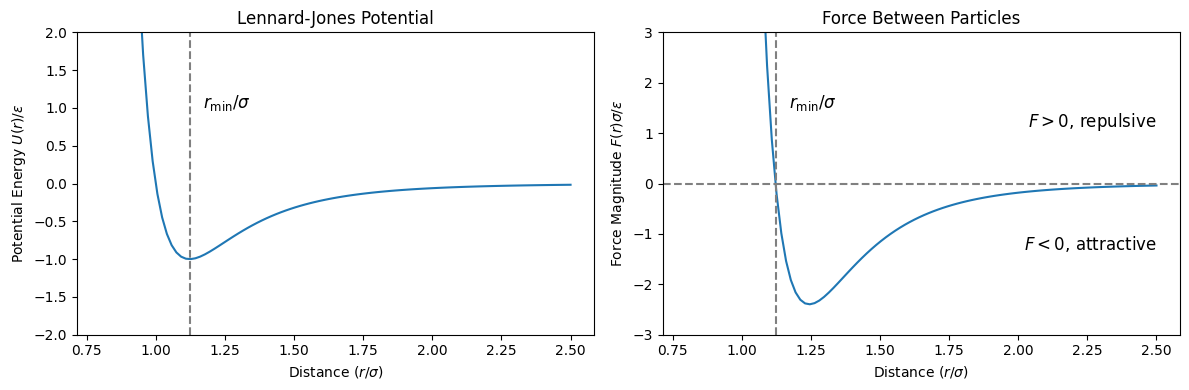

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lennard-Jones potential energy function
def U(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# Lennard-Jones force magnitude function
def F(r, epsilon=1.0, sigma=1.0):
    return 24 * epsilon * ((2 * (sigma / r)**12) - ((sigma / r)**6)) / r

# Distance between the particles
r = np.linspace(0.8, 2.5, 100)

# Avoid division by zero
r = r[r != 0]

# Plot the potential energy and force as functions of distance
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Potential Energy Plot
axs[0].plot(r, U(r))
axs[0].set_xlabel('Distance ($r/\\sigma$)')
axs[0].set_ylabel('Potential Energy $U(r)/\\epsilon$')
axs[0].set_title('Lennard-Jones Potential')
axs[0].axvline(2**(1/6), color='gray', linestyle='--')
axs[0].annotate('$r_{\\rm min}/\\sigma$', xy=(2**(1/6) + 0.05, 1), fontsize=12)
axs[0].set_ylim(-2, 2)

# Force Plot
axs[1].plot(r, F(r))
axs[1].set_xlabel('Distance ($r/\\sigma$)')
axs[1].set_ylabel('Force Magnitude $F(r)\\sigma/\\epsilon$')
axs[1].set_title('Force Between Particles')
axs[1].axvline(2**(1/6), color='gray', linestyle='--')
axs[1].annotate('$r_{\\rm min}/\\sigma$', xy=(2**(1/6) + 0.05, 1.5), fontsize=12)
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].annotate('$F > 0$, repulsive', xy=(2.5, 1), fontsize=12, va='bottom', ha='right')
axs[1].annotate('$F < 0$, attractive', xy=(2.5, -1), fontsize=12, va='top', ha='right')
axs[1].set_ylim(-3, 3)

plt.tight_layout()
plt.show()

The potential energy reaches its minimum at $r = 2^{1/6} \sigma$, representing the equilibrium separation. For $r < r_{\rm min}$, the force is positive (repulsive), pushing the particles apart. For $r > r_{\rm min}$, the force is negative (attractive), pulling the particles together.

## Verlet Integration

The Verlet integration algorithm is a widely used numerical method for integrating Newton's equations of motion in molecular dynamics simulations. It is particularly favored for its simplicity, time-reversibility, and good energy conservation properties over long simulations.

### Derivation of the Verlet Algorithm

```{admonition} Taylor Series Expansion
The Taylor series expansion of a function $f(x)$ around a point $x = a$ is given by

$$
f(x) = f(a) + f'(a)(x - a) + \frac{1}{2}f''(a)(x - a)^2 + \frac{1}{6}f'''(a)(x - a)^3 + \ldots
$$

where $f'(a)$, $f''(a)$, $f'''(a)$ are the first, second, and third derivatives of $f(x)$ evaluated at $x = a$, respectively.
```

The Verlet algorithm is derived from the **Taylor series expansions** of the position of a particle at times $t + \Delta t$ and $t - \Delta t$, *i.e.*,

$$
\begin{align*}
\mathbf{r}(t + \Delta t) &= \mathbf{r}(t) + \left.\frac{d\mathbf{r}}{dt}\right|_{t} \Delta t + \frac{1}{2}\left.\frac{d^2\mathbf{r}}{dt^2}\right|_{t} \Delta t^2 + \frac{1}{6}\left.\frac{d^3\mathbf{r}}{dt^3}\right|_{t} \Delta t^3 + \mathcal{O}(\Delta t^4) \\
&= \mathbf{r}(t) + \mathbf{v}(t) \Delta t + \frac{1}{2} \mathbf{a}(t) \Delta t^2 + \frac{1}{6} \mathbf{r}^{(3)}(t) \Delta t^3 + \mathcal{O}(\Delta t^4)
\end{align*}
$$

$$
\begin{align*}
\mathbf{r}(t - \Delta t) &= \mathbf{r}(t) - \mathbf{v}(t) \Delta t + \frac{1}{2} \mathbf{a}(t) \Delta t^2 - \frac{1}{6} \mathbf{r}^{(3)}(t) \Delta t^3 + \mathcal{O}(\Delta t^4)
\end{align*}
$$

Here, $\mathbf{v}(t)$ is the velocity, $\mathbf{a}(t)$ is the acceleration, and $\mathbf{r}^{(3)}(t)$ is the third derivative of position with respect to time. Adding the two equations,

$$
\begin{align*}
\mathbf{r}(t + \Delta t) + \mathbf{r}(t - \Delta t) &= 2 \mathbf{r}(t) + \mathbf{a}(t) \Delta t^2 + \mathcal{O}(\Delta t^4)
\end{align*}
$$

Rewriting the equation,

$$
\mathbf{r}(t + \Delta t) = 2 \mathbf{r}(t) - \mathbf{r}(t - \Delta t) + \mathbf{a}(t) \Delta t^2 + \mathcal{O}(\Delta t^4)
$$

Since acceleration $\mathbf{a}(t)$ is related to the force $\mathbf{F}(t)$ by Newton's second law $\mathbf{F}(t) = m \mathbf{a}(t)$, we can write

$$
\mathbf{a}(t) = \frac{\mathbf{F}(t)}{m}
$$

The **final Verlet update formula** is

$$
\mathbf{r}(t + \Delta t) = 2 \mathbf{r}(t) - \mathbf{r}(t - \Delta t) + \frac{\mathbf{F}(t)}{m} \Delta t^2
$$

This formula allows us to compute the new position $\mathbf{r}(t + \Delta t)$ using the current position $\mathbf{r}(t)$, the previous position $\mathbf{r}(t - \Delta t)$, and the force $\mathbf{F}(t)$ at time $t$.

### Calculating Velocities for Kinetic Energy

```{admonition} Central Difference Approximation
The central difference approximation for the derivative of a function $f(x)$ at a point $x = a$ is given by

$$
f'(a) \approx \frac{f(a + \Delta x) - f(a - \Delta x)}{2 \Delta x}
$$

where $\Delta x$ is a small step size.
```

While the Verlet algorithm updates positions efficiently, velocities are also needed to compute kinetic energies and other properties. An estimate of the velocity at time $t$ can be obtained using a **central difference approximation**, *i.e.*,

$$
\mathbf{v}(t) = \frac{\mathbf{r}(t + \Delta t) - \mathbf{r}(t - \Delta t)}{2 \Delta t} + \mathcal{O}(\Delta t^2)
$$

This estimation provides velocities consistent with the positions calculated by the Verlet algorithm.

### Verlet Integration Algorithm Steps

1. Set initial positions $\mathbf{r}(-\Delta t)$ and $\mathbf{r}(0)$.
2. Calculate the forces $\mathbf{F}(t)$ based on the current positions $\mathbf{r}(t)$.
3. Update positions using the final Verlet update formula.
4. Estimate velocities using the central difference approximation for analysis or for calculating kinetic energy.
5. Compute kinetic and potential energies based on velocities and positions.
6. Advance to the next time step by updating $t \leftarrow t + \Delta t$ and repeat steps 2–6.

```{admonition} Practical Considerations
:class: tip
- **Initial Conditions:** Physically realistic initial positions are crucial for the stability and accuracy of the simulation.
- **Time Step Selection:** The choice of $\Delta t$ affects the accuracy and stability; it should be small enough to capture the dynamics of the system.
- **Energy Conservation:** Monitoring total energy helps ensure the simulation is proceeding correctly; significant drifts may indicate numerical issues.
```

```{admonition} Limitations
:class: warning
- **Velocity Accuracy:** Velocities are not as accurately determined as positions; if precise velocities are required, alternatives like the [Velocity Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) may be preferable.
- **Higher-Order Forces:** For systems where forces depend on higher-order derivatives, additional considerations are needed.
```

## Implementation

Let's implement the Verlet algorithm to simulate the motion of two particles interacting via the Lennard-Jones potential in one dimension. We'll calculate the forces acting on the particles using the Lennard-Jones potential energy and force functions. The particles will start from rest near the equilibrium separation. We'll update their positions using the Verlet algorithm, calculate their velocities, and compute the kinetic and potential energies over time.

### Code Implementation

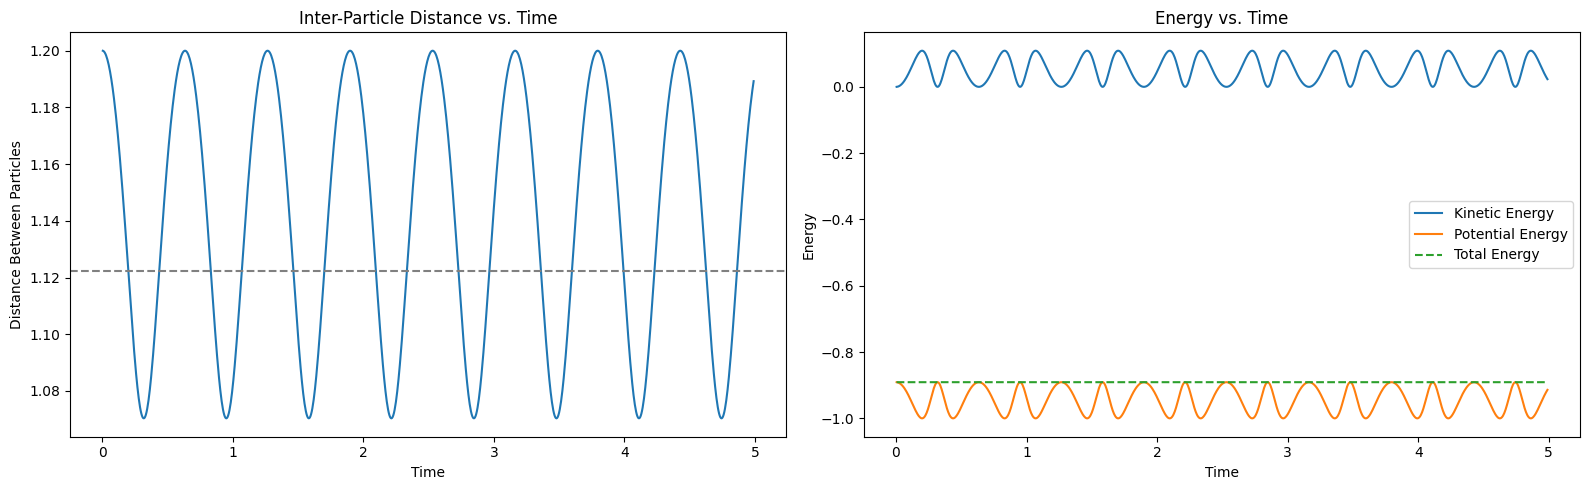

In [2]:
# Simulation parameters
epsilon = 1.0    # Depth of the potential well
sigma = 1.0      # Distance at which the potential is zero
m = 1.0          # Mass of each particle
dt = 0.005       # Time step size
nsteps = 1000    # Number of time steps

# Initialize position arrays for two particles
positions = np.zeros((nsteps, 2))

# Set initial positions at time t = 0
positions[0] = [0.0, 1.2]    # Slightly perturbed from equilibrium
positions[1] = positions[0]  # Starting from rest

# Initialize arrays for velocities and forces
velocities = np.zeros((nsteps, 2))
forces = np.zeros((nsteps, 2))

# Initialize arrays for kinetic and potential energies
kinetic_energy = np.zeros(nsteps)
potential_energy = np.zeros(nsteps)
total_energy = np.zeros(nsteps)

# Main Verlet integration loop
for i in range(1, nsteps - 1):
    # Compute the distance between the particles
    r12 = positions[i, 0] - positions[i, 1]
    r12_abs = np.abs(r12)

    # Compute the force magnitude and direction
    force_mag = F(r12_abs, epsilon, sigma)
    force_dir = np.sign(r12)
    force = force_mag * force_dir

    # Assign forces to each particle (Newton's third law)
    forces[i, 0] = force       # Force on particle 0
    forces[i, 1] = -force      # Equal and opposite force on particle 1

    # Update positions using the Verlet algorithm
    positions[i + 1] = (2 * positions[i] - positions[i - 1] +
                        (forces[i] / m) * dt**2)

    # Estimate velocities using central difference
    velocities[i] = (positions[i + 1] - positions[i - 1]) / (2 * dt)

    # Compute kinetic energy
    kinetic_energy[i] = 0.5 * m * np.sum(velocities[i]**2)

    # Compute potential energy
    potential_energy[i] = U(r12_abs, epsilon, sigma)

    # Compute total energy
    total_energy[i] = kinetic_energy[i] + potential_energy[i]

# Time array for plotting
time = np.arange(nsteps) * dt

# Plot the distance between the particles and (kinetic, potential, total) energies over time
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Distance plot
axs[0].plot(time[1:-1], np.abs(positions[1:-1, 1] - positions[1:-1, 0]))
axs[0].axhline(2**(1/6) * sigma, color='gray', linestyle='--', label='Equilibrium Distance')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Distance Between Particles')
axs[0].set_title('Inter-Particle Distance vs. Time')

# Energy plot
axs[1].plot(time[1:-1], kinetic_energy[1:-1], label='Kinetic Energy')
axs[1].plot(time[1:-1], potential_energy[1:-1], label='Potential Energy')
axs[1].plot(time[1:-1], total_energy[1:-1], label='Total Energy', linestyle='--')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs. Time')
axs[1].legend()

plt.tight_layout()
plt.show()

### Observations

The left plot shows the distance between the particles as a function of time. The particles exhibit oscillatory motion around the equilibrium separation due to the interplay of attractive and repulsive forces. The right plot shows the kinetic, potential, and total energies of the system as functions of time. The total energy remains approximately constant, showcasing the energy-conserving property of the Verlet algorithm. The kinetic and potential energies oscillate out of phase, indicating the exchange of energy between motion and interaction potential.

```{admonition} Notes and Considerations
:class: tip
- **Time Step Selection (`dt`):**
  - A smaller time step improves accuracy but increases computational cost.
  - If `dt` is too large, the simulation may become unstable or inaccurate.
- **Simulation Dimension:**
  - This example is one-dimensional for simplicity.
  - Extending to three dimensions involves vectorizing positions, velocities, and forces.
- **Physical Units:**
  - The simulation uses reduced units where $\epsilon = 1$, $\sigma = 1$, and $m = 1$.
  - In practical simulations, you can use units consistent with the physical system.
- **Initial Conditions:**
  - The initial positions significantly influence the system's behavior.
```